# Yann LeCun's LeNet-5 in PyThorc

## Setup

In [1]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

"""
Per selezionare la GPU su Google Colab, segui questi passaggi:
1. Clicca su "Runtime" nella barra del menu in alto.
2. Seleziona "Change runtime type".
3. Nella finestra pop-up, seleziona "GPU" nell'opzione "Hardware accelerator".
4. Fai clic su "Save" per applicare le modifiche.
"""
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%config InlineBackend.figure_format = 'retina' # migliora la qualità per le immagini dei grafici

In [4]:
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

## Helper Function

In [5]:
def get_accuracy(model, data_loader, device):
    '''
    Calcola l'accuratezza del modello sui dati forniti dal data loader.

    Args:
        model (torch.nn.Module): Il modello da valutare.
        data_loader (torch.utils.data.DataLoader): Il data loader contenente i dati di valutazione.
        device (torch.device): La device su cui eseguire il calcolo (CPU o GPU).

    Returns:
        float: L'accuratezza del modello sui dati di valutazione.
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Plotta le curve di perdita durante il training e la validazione.

    Args:
        train_losses (list): Lista delle perdite durante il training.
        valid_losses (list): Lista delle perdite durante la validazione.
    '''

    plt.style.use('seaborn') # Cambia temporaneamente lo stile del plot a seaborn

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()
    fig.show()

    plt.style.use('default') # Ripristina lo stile di default

def train(train_loader, model, criterion, optimizer, device):
    '''
    Esegue il passo di training durante il loop di training.

    Args:
        train_loader (torch.utils.data.DataLoader): Il data loader contenente i dati di training.
        model (torch.nn.Module): Il modello da addestrare.
        criterion: La funzione di perdita.
        optimizer: L'ottimizzatore.
        device (torch.device): La device su cui eseguire il training (CPU o GPU).

    Returns:
        tuple: Tuple contenente il modello, l'ottimizzatore e la perdita media dell'epoca.
    '''

    model.train() # Modello in training mode
    running_loss = 0


    for X, y_true in train_loader: # Itero sui valori del dataset di training


        optimizer.zero_grad() # Azzero i gradienti di ottimizzazione ad ogni epoca

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_hat, _ = model(X) # predizione del modello
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    # Calcolo della loss media dell'epoca
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Esegue la fase di validazione durante il loop di training.

    Args:
        valid_loader (torch.utils.data.DataLoader): Il data loader contenente i dati di validazione.
        model (torch.nn.Module): Il modello da valutare.
        criterion: La funzione di perdita.
        device (torch.device): La device su cui eseguire la validazione (CPU o GPU).

    Returns:
        tuple: Tuple contenente il modello e la perdita media dell'epoca.
    '''
    model.eval()  # Non posso fare update dei parametri: modello in eval mode
    model.to(device)
    running_loss = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and calcolo loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset) # perdita media epoca

    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Esegue il loop di training completo (training -> validation -> training -> ...).

    Args:
        model (torch.nn.Module): Il modello da addestrare.
        criterion: La funzione di perdita.
        optimizer: L'ottimizzatore.
        train_loader (torch.utils.data.DataLoader): Il data loader contenente i dati di training.
        valid_loader (torch.utils.data.DataLoader): Il data loader contenente i dati di validazione.
        epochs (int): Il numero totale di epoche.
        device (torch.device): La device su cui eseguire il training (CPU o GPU).
        print_every (int): La frequenza di stampa delle metriche durante il training.

    Returns:
        tuple: Tuple contenente il modello, l'ottimizzatore e le liste delle perdite di training e validation.
    '''

    # variabili per lo storico delle metriche
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Itero sul numero di epoche
    for epoch in range(0, epochs):

        # Training

        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Validation

        # no update dei gradienti
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

## Data

In [6]:
# Define transforms: le trasformazioni vengono applicate alle immagini prima di usarle nel modello.
# transforms.ToTensor() scala le immagini in un range [0,1].
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# Download e creazione del dataset.
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)
'''
Dataloader: funzioni iteratrici che per ogni epoca prelevano un batch (#n immagini).
'''
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True) # True: rimescola immagini nel batch.

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False) # False: la rete non è in training.

100%|██████████| 9912422/9912422 [00:00<00:00, 105389436.76it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97219657.96it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29673404.63it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2458449.96it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



## Plotto le immagini

In [7]:
ROW_IMG = 10
N_ROWS = 5

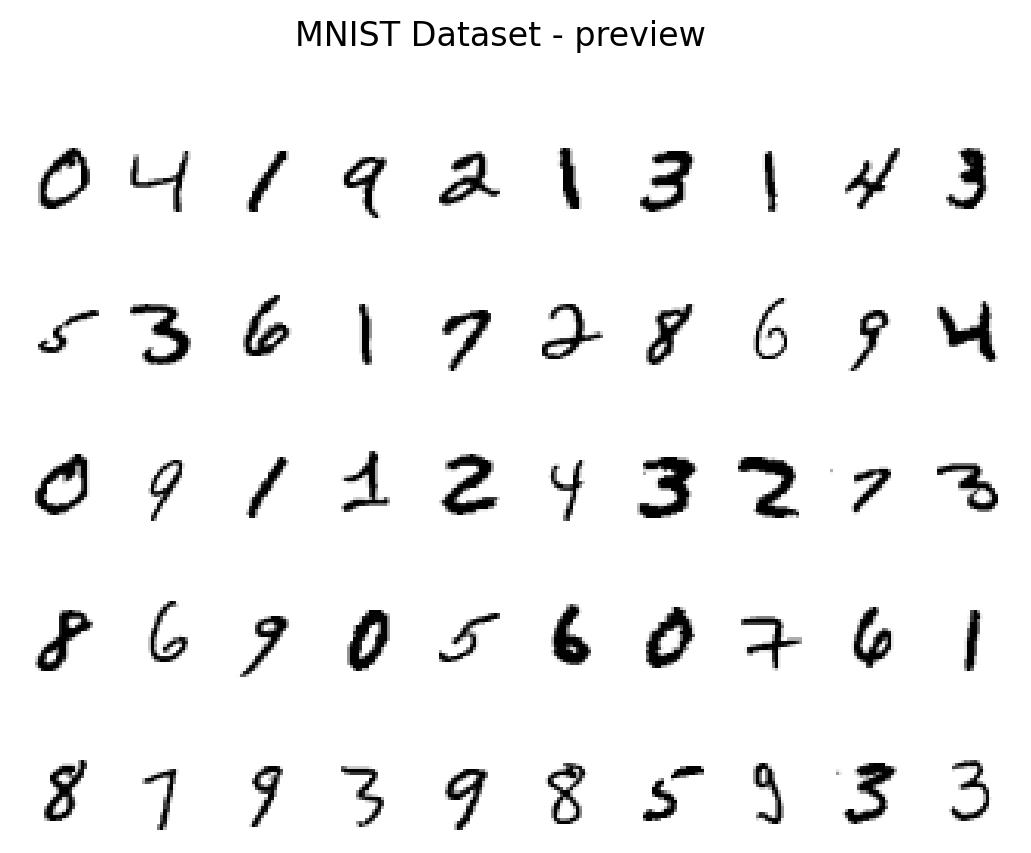

In [8]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap = 'gray_r')
fig.suptitle('MNIST Dataset - preview');

## Implementazione di LeNet-5

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self, n_classes):
        """
        Inizializza la rete LeNet5.

        Args:
            n_classes (int): Numero di classi nel problema di classificazione.
        """
        super(LeNet5, self).__init__()

        # Definizione dei tre blocchi di convoluzione:
        self.feature_extractor = nn.Sequential(
            # Primo blocco di convoluzione
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),  # Funzione di attivazione (tangente iperbolica)
            nn.AvgPool2d(kernel_size=2),  # Funzione di pooling (average)

            # Secondo blocco di convoluzione
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),

            # Terzo blocco di convoluzione
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        # Blocco di classificazione
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )

    def forward(self, x):
        """
        Definisce il flusso di dati attraverso la rete durante la fase di forward.

        Args:
            x (torch.Tensor): Input della rete.

        Returns:
            tuple: Una tupla contenente i logits e le probabilità predette.
        """
        # Estrazione delle feature attraverso i blocchi di convoluzione
        x = self.feature_extractor(x)

        # Flattening e ottenimento di un vettore di flattening
        x = torch.flatten(x, 1)

        # Passaggio del vettore di flattening al blocco di classificazione
        logits = self.classifier(x)

        # Traduzione in probabilità del vettore di logits
        probs = F.softmax(logits, dim=1)
        return logits, probs


## Ottimizzatore

In [11]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
# Applico ottimizzatore ADAM
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Classificazione a 2+ classi
criterion = nn.CrossEntropyLoss()

17:03:48 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
17:04:20 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
17:04:52 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
17:05:25 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
17:05:59 --- Epoch: 4	Train loss: 0.0343	Valid loss: 0.0415	Train accuracy: 99.25	Valid accuracy: 98.76
17:06:34 --- Epoch: 5	Train loss: 0.0301	Valid loss: 0.0425	Train accuracy: 99.43	Valid accuracy: 98.70
17:07:04 --- Epoch: 6	Train loss: 0.0241	Valid loss: 0.0475	Train accuracy: 99.39	Valid accuracy: 98.60
17:07:34 --- Epoch: 7	Train loss: 0.0220	Valid loss: 0.0485	Train accuracy: 99.42	Valid accuracy: 98.50
17:08:04 --- Epoch: 8	Train loss: 0.0191	Valid loss: 0.0528	Train accuracy: 99.44	Valid accuracy: 98.54
17:08:34 --- Epoch: 9	Train loss: 0.0176	Valid loss: 0.0532	Trai

<ipython-input-5-f5fd0726be6a>:41: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') # Cambia temporaneamente lo stile del plot a seaborn


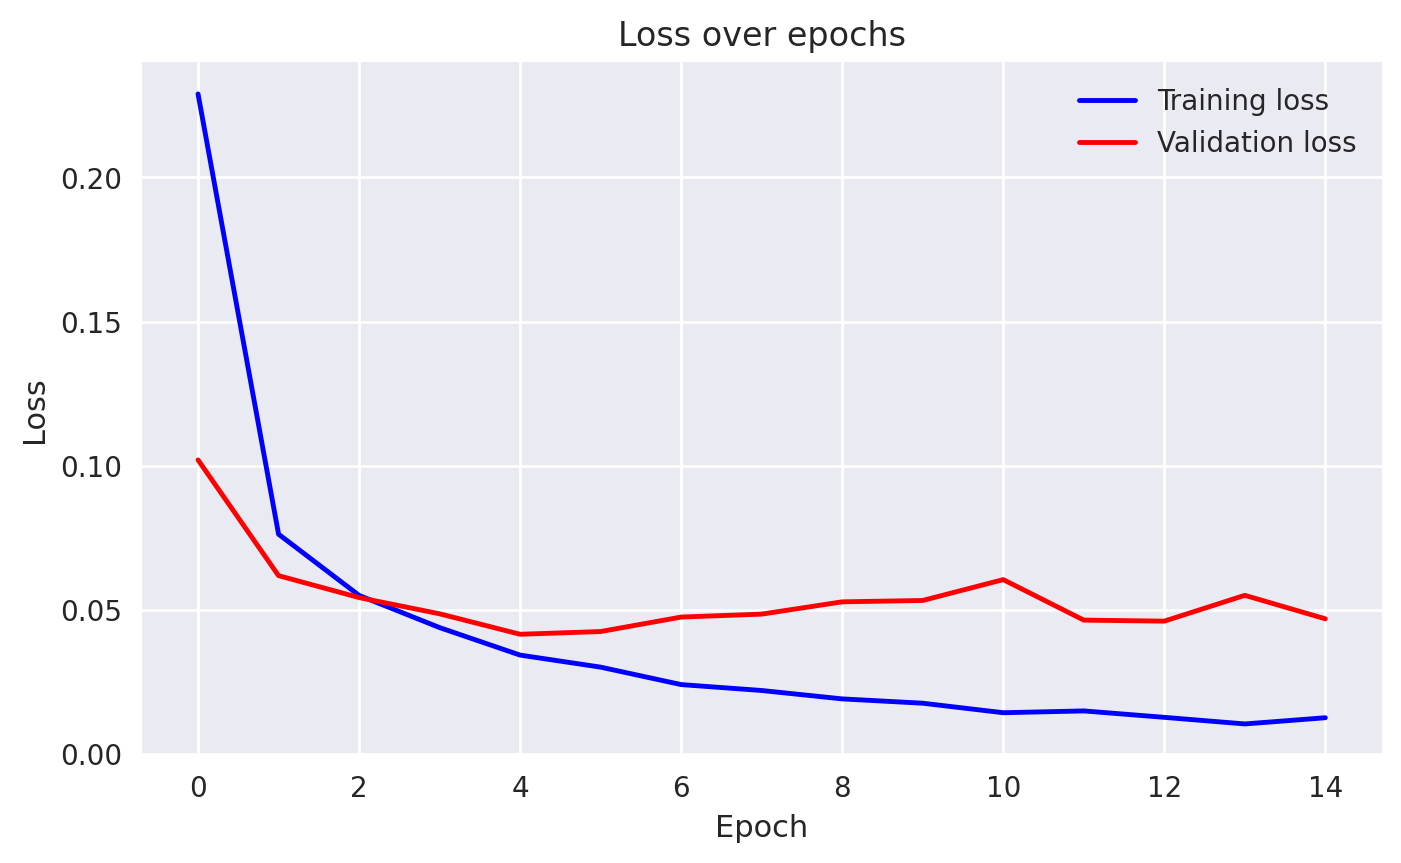

In [12]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

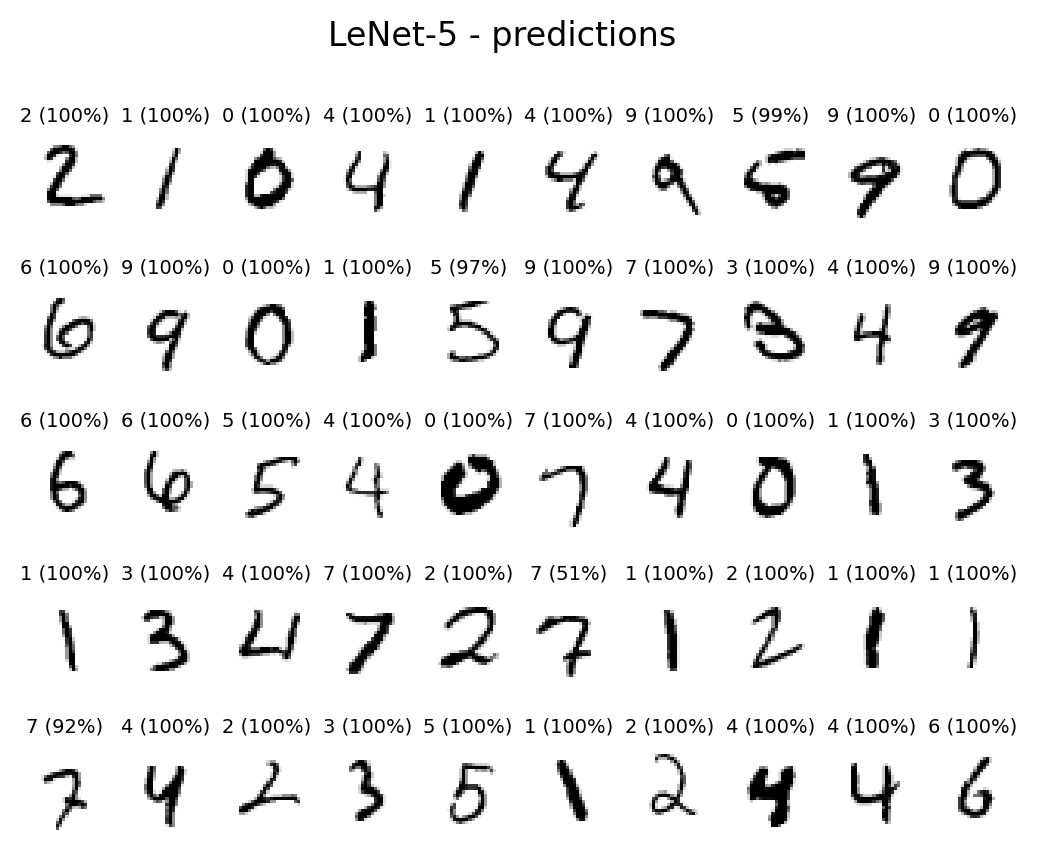

In [13]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')

    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0).to(DEVICE))

    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');